In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import GridSearchCV
import math as ma
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import autograd.numpy as np

# To do elementwise differentiation:
from autograd import elementwise_grad as egrad 
from autograd import grad

In [7]:

def mini_batch_creator(X, y, batch_size):
        mini_batches = [] # empty list for the mini batchess
        data_matrix = np.hstack((X, y.reshape(-1, 1)))  # Column 0 to n-1 is data, column n is the target data
        
        np.random.shuffle(data_matrix) # would not be stochastic if it didnt include random. 
        
        m = data_matrix.shape[0] // batch_size # number of minibatches number of rows/datapoints divided by selected batchsize
        i=0
        for i in range(m):
            mini_batch = data_matrix[i * batch_size:(i + 1)*batch_size, :]#creating a mini batch
            X_mini = mini_batch[:, :-1] #evry thing except the last column
            Y_mini = mini_batch[:, -1] #exclusively the last column
            mini_batches.append((X_mini, Y_mini)) # has 2 arrays, first array contains the minibatches for x and the second for y
        if data_matrix.shape[0] % batch_size != 0:
            mini_batch = data_matrix[i * batch_size:data_matrix.shape[0]]
            X_mini = mini_batch[:, :-1]
            Y_mini = mini_batch[:, -1]
            mini_batches.append((X_mini, Y_mini))
        return mini_batches

In [8]:
def Sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

In [9]:
def pred_log(x,weights):
    z_pred = Sigmoid(x @ weights)
    
    for i in range(len(z_pred)):
        if z_pred[i] >= 0.5:
            z_pred[i] = int(1)
        else:
            z_pred[i] = int(0)
    return z_pred

In [10]:
def learning_schedule(eta,decay,epoch):
    return (eta/(1+decay*epoch))

In [65]:
def LOGISTIC_SGD(X_train, y_train, eta, lmb,batch_size = 20,schedule = False):
    weight_innit = X_train.shape[1]
    n_epochs = 100
    weights = np.random.randn(weight_innit)
    
    batch_size = 20
    if (schedule == False):
        for i in range(n_epochs):
            
            mini_batches = mini_batch_creator(X_train,y_train,batch_size)
            for batch in mini_batches:
                
                X_mini_i,Y_mini_i = batch
                gradient = -X_mini_i.T @ (Y_mini_i - Sigmoid(X_mini_i@weights)) + lmb*weights
                weights -= eta*gradient
        return weights
    
    elif (schedule == True):
        for epoch in range(n_epochs):
            mini_batches = mini_batch_creator(X_train,y_train,batch_size)
            for batch in mini_batches:
                X_mini_i,Y_mini_i = batch
                gradient = -X_mini_i.T @ (Y_mini_i - Sigmoid(X_mini_i@weights)) + lmb*weights
                eta = learning_schedule(eta,1e-5,epoch)
                weights -= eta*gradient
        return weights

   
    

# initilize data

In [66]:
from sklearn.datasets import load_breast_cancer

BC = load_breast_cancer()

In [83]:
np.random.seed(655)
X = BC.data
z = BC.target
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [84]:
X_train.shape

(455, 30)

In [85]:
np.random.seed(655)
etas = np.logspace(-8,-2,7)
lambdas = np.logspace(-7,-1,7)

from sklearn.metrics import accuracy_score

In [79]:
acc_score_schedule = np.zeros((len(lambdas),len(etas)))
acc_score_Noschedule = np.zeros((len(lambdas),len(etas)))

In [86]:
np.random.seed(655)
for i in range(len(lambdas)):
    lmb =lambdas[i]
    for j in range(len(etas)):
        eta = etas[j]
        weights_T = LOGISTIC_SGD(X_train,z_train,eta,lmb,schedule = True)
        weights_F = LOGISTIC_SGD(X_train,z_train,eta,lmb,schedule = False)
        
        pred_T = pred_log(X_test,weights_T)
        pred_F = pred_log(X_test,weights_F)
        
        acc_score_schedule[i,j] = accuracy_score(z_test,pred_T)
        acc_score_Noschedule[i,j] = accuracy_score(z_test,pred_F)
df_grid_schedule = pd.DataFrame(acc_score_schedule, index = lambdas, columns = etas)
df_grid_Noschedule= pd.DataFrame(acc_score_Noschedule, index = lambdas, columns = etas)

Text(0.5, 1.0, 'Accuracy score with scheduler')

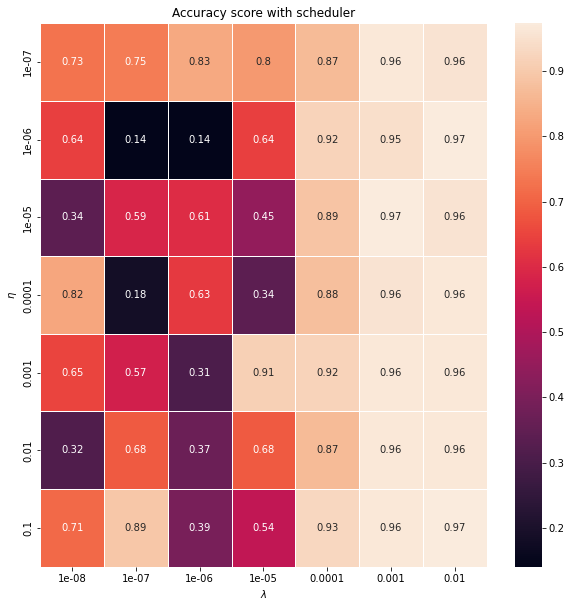

In [90]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_grid_schedule,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
ax.set_title("Accuracy score with scheduler")

Text(0.5, 1.0, 'Accuracy score without scheduler')

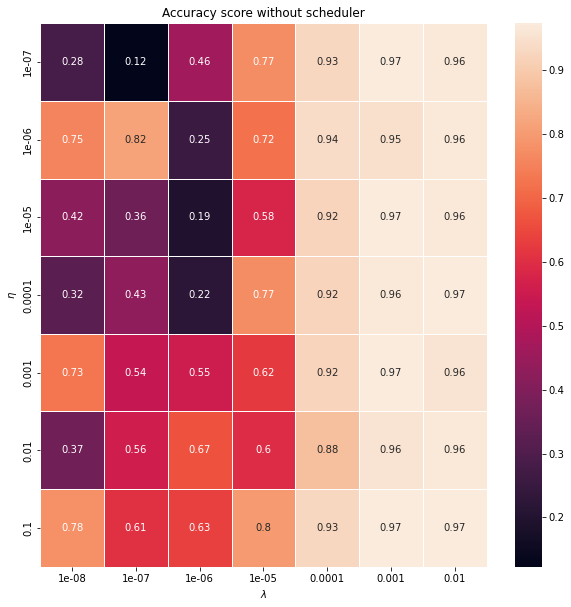

In [89]:
fig, ax = plt.subplots(figsize=(10,10))   
sns.heatmap(df_grid_Noschedule,annot =True, linewidths=.8, ax=ax,fmt='.2g')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
ax.set_title("Accuracy score without scheduler")

In [92]:
df_grid_schedule.max()

1.000000e-08    0.824561
1.000000e-07    0.894737
1.000000e-06    0.833333
1.000000e-05    0.912281
1.000000e-04    0.929825
1.000000e-03    0.973684
1.000000e-02    0.973684
dtype: float64

In [93]:
df_grid_Noschedule.max()

1.000000e-08    0.780702
1.000000e-07    0.815789
1.000000e-06    0.666667
1.000000e-05    0.798246
1.000000e-04    0.938596
1.000000e-03    0.973684
1.000000e-02    0.973684
dtype: float64